### Import

In [1]:
# Libraries
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

# Files
from vehicle import *
from plotting import *
from simulate import *
from mpc import *
from global_path_planning import *
from obstacles import *
from quadrotor_mpc import *


### Simulation Input Parameters
state vector of a quadrotor $[x,y,z,\phi,\theta,\psi,\dot{x},\dot{y},\dot{z},\dot{\phi},\dot{\theta},\dot{\psi}]$

input vector of a quadrotor $[\omega_{1}^{2},\omega_{2}^{2},\omega_{3}^{2},\omega_{4}^{2}]$

In [7]:
#### MPC Properties
dt = 0.1                  # Time step [s]
N = 30                # Time Horizon

####  Simulation/Problem Parameters
x_init = np.array([9, 2, 2] + [0]*9)
x_target_last = np.array([10, 48, 2] + [0]*9)
T = 3                                   # Simulation time [s]

#### Drone Velocity & Acceleration Constraints
pos_constraints = [0, 20, 0, 50, 0, 20]         # Position Constraints [m]:    [x_min, x_max, y_min, y_max, z_min, z_max	] 
rpm_lim = 8000
cost_weights = [120, 20, 0, 0, 0.1]         # Cost Weights [pos, att, vel, ang_vel, inputs]

#### Obstacles
static_cost = 1000
dynamic_cost = 1000

#### Waypoint Radius Threshold
waypoint_radius = 3


In [3]:
#### Obstacle Definition and Initialization

## Define Obstacles
V_obstacles = [[10, 20, 4], [18, 30, 3], [7, 40, 5]]
V_move_obstacles = [[20, 40, -0.7, 0, 4], [17, 0, 0, 1, 4], [5, 0, 0, 1, 2]]  # [center_x, center_y, vel_x, vel_y, radius]
H_obstacles = []         # [center_x, center_y, radius]
H_move_obstacles = []  # [center_x, center_y, vel_x, vel_y, radius]

## Initialize Obstacles
obstacles, move_obstacles = init_obstacles(V_obstacles, V_move_obstacles, H_obstacles, H_move_obstacles, static_cost, dynamic_cost)

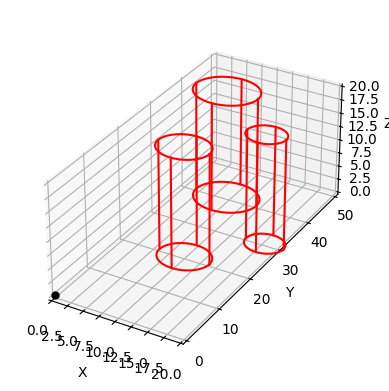

RRT*


IntProgress(value=0, max=1000)

Goal found


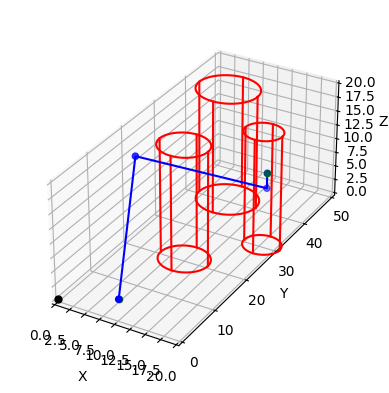

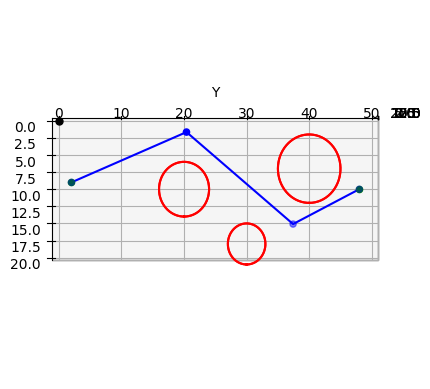

In [4]:
# Create Static World
World = World_3D([pos_constraints[0], pos_constraints[1]], [pos_constraints[2], pos_constraints[3]], [pos_constraints[4], pos_constraints[5]], obstacles, move_obstacles, obstacle_margin=0.5)
World.plot()

start = x_init[:3]
goal = x_target_last[:3]

print("RRT*")
path_rrt = rrt_star(World, start, goal, radius=10, max_iter=1000)
print(path_rrt)
World.plot(path_rrt)
World.plot2d(path_rrt)


In [8]:
# Setup Controller and Simulate
quadrotor = Quadrotor(dt)
controller = lambda x_init, current_wp, last_plan : quadrotor_mpc_control(quadrotor, N, x_init, current_wp, last_plan, pos_constraints, rpm_lim, cost_weights, obstacles, move_obstacles)
states, inputs, plans, timesteps, target_state = simulate(dt, T, x_init, x_target_last, N, controller, move_obstacles, path_rrt, waypoint_radius, num_states=12, num_inputs=4)

Timesteps: 30
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1932
Number of nonzeros in inequality constraint Jacobian.:      570
Number of nonzeros in Lagrangian Hessian.............:     1383

Total number of variables............................:      492
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      372
Total number of inequality constraints...............:      390
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      210
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3704223e+06 9.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00

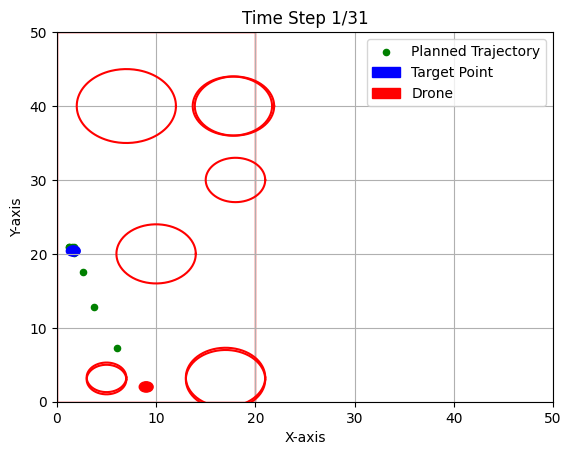

In [ ]:
## Plot Simulation
obstacles, move_obstacles = init_obstacles(V_obstacles, V_move_obstacles, H_obstacles, H_move_obstacles, static_cost, dynamic_cost)

def update(frame):
    # Clear previous frame
    plt.cla()

    # Plot Path for current state
    plt.scatter(plans[0][:, frame], plans[1][:, frame], c='g', s=20, label = "Planned Trajectory")

    # Plot current state
    TargetPoint = plt.Circle((target_state[0][frame], target_state[1][frame]), 0.7, color='b', fill=True, label = "Target Point")
    plt.gca().add_patch(TargetPoint)

    drone = plt.Circle((states[0][frame], states[1][frame]), 0.7, color='r', fill=True, label = "Drone")
    plt.gca().add_patch(drone)
    
    MovingObstacleConvert(move_obstacles, dt)

    # Plot Environment
    World.plot2d_ax(plt.gca())

    for move_obstacle in move_obstacles:
        move_obstacle.plot_xy(plt.gca(), 'red')

    # Env Boundaries
    x = pos_constraints[0]
    y = pos_constraints[2]
    width = pos_constraints[1]-x
    height = pos_constraints[3]-x
    rectangle = patches.Rectangle((x, y), width, height, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rectangle)

    plt.legend()
    plt.title(f'Time Step {frame + 1}/{len(states[1])}')  # Set title for each frame
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.grid()

# Create the animation
fig = plt.figure()
ani = FuncAnimation(fig, update, frames=len(states[1]), interval=100)

# Display the animation within the Jupyter Notebook using HTML
HTML(ani.to_jshtml())
